## Data

[A data set of MRI images used to diagnose dementia in Alzheimer's patients.](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset)


In [ ]:
import os
path = os.getcwd()
print(f"path:\n {path}\n")
print(f"contents:\n {os.listdir(path)}")

from zipfile import ZipFile

zip = ZipFile('AlzheimersDataAll_augmented.zip', 'r')
zip.extractall()
zip.close()

path:
 /content

contents:
 ['.config', '__MACOSX', 'Dataset', 'AlzheimersDataAll_augmented.zip', '.ipynb_checkpoints', 'sample_data']


In [ ]:
os.listdir(path + '/Dataset') #have a look at the folders in the data set

['Non_Demented',
 'Very_Mild_Demented',
 'Mild_Demented',
 '.DS_Store',
 'Moderate_Demented']

In [ ]:
#We may be able to whittle this down

#!pip install tensorflow
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img

import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree


print("TensorFlow Version:", tf.__version__) # it's good to know what version you're using

TensorFlow Version: 2.12.0


In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Splitting the data into three datasets: train, test, and validation
#!pip install split-folders
import splitfolders
splitfolders.ratio(path + '/Dataset', output="output", seed=1234, ratio=(0.7, 0.1,0.2))

Copying files: 6528 files [00:00, 7152.68 files/s]


In [ ]:
#Data prep

IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
label_mode='int',
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
label_mode='int',
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
label_mode='int',
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 4569 files belonging to 4 classes.
Found 1307 files belonging to 4 classes.
Found 652 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

The image shape is (None, 128, 128, 3). 

The "None" dimension can take any scalar value, and allows us to use any number of samples for our input during training.

The next two dimensions are the height and width of our images (128 x 128). The final dimension indicates our three color channels (RGB). Our MRI images are grayscale, so the R, G, and B channels will contain the same value for each pixel in the image. An avenue for further exploration would be to use the color_mode='grayscale' modifier in the image_dataset_from_directory function.

Let's look at some of our training images.

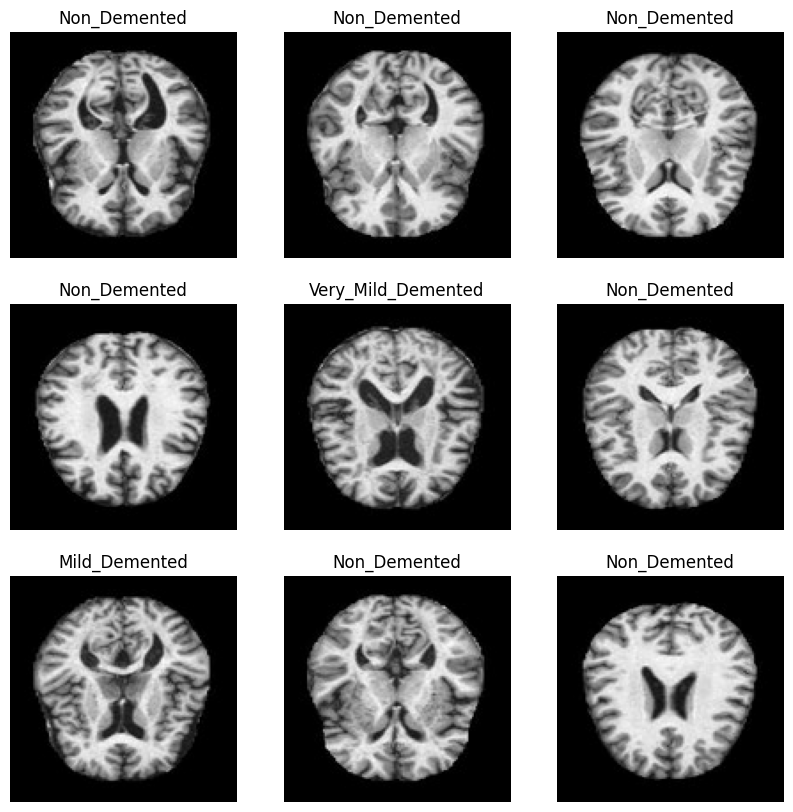

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As an untrained person, it's not easy to see the difference in MRI scans for the different classes of dementia. Thankfully, it will take less time to train our CNN to see the differences than it would to train you!

Sometimes when training a model, you have more examples of one class than you do for another. That's the case in our data set:

<function matplotlib.pyplot.show(close=None, block=None)>

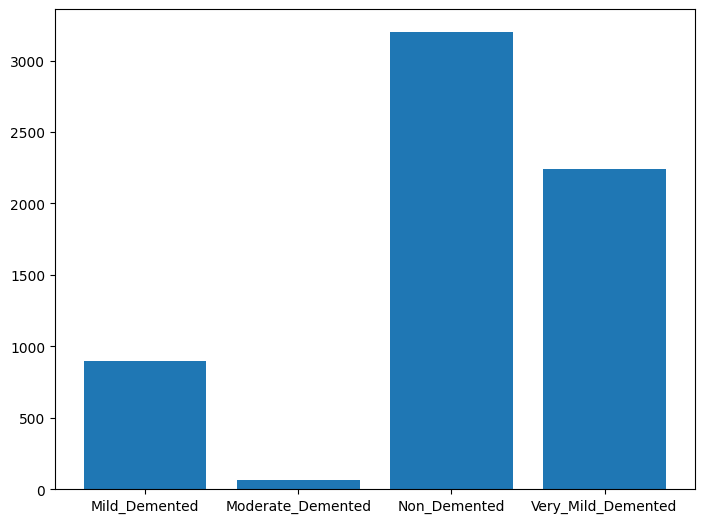

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

# Building the Model

Last time we built using a model that had alternating convolutional layers and pooling layers.

*  [ Convolutional layers](https://developers.google.com/machine-learning/glossary/#convolutional-layer) (Conv2D in the code below) pass a two dimensional matrix (3x3 in the code below) along the input matrix (the RGB values of each 3x3 group of pixels in the input image) to produce a new matrix.
*    [Pooling layers](https://developers.google.com/machine-learning/glossary/#pooling) (MaxPooling2D in the code below) reduce the matrices produced by the convolutional layer to a smaller matrix, thereby condensing the information gained.


Now we will try to apply an ensemble of pre-trained models called Resnet50 + Unet:


# **Resnet-50 Summary**


ResNet-50 is a popular deep learning model used for image recognition and classification tasks. It is a part of the Residual Network (ResNet) family, which was created to make training deep neural networks easier and more effective.

The main idea behind ResNet is the use of residual connections, also known as skip connections. These connections help the network learn more effectively by allowing it to focus on learning new features from the input data. ResNet-50 has 50 layers in total, including different types of layers like convolutional layers, activation layers, and fully connected layers.

One of the reasons ResNet-50 is so popular is because it's often used as a pre-trained model for transfer learning. This means that the model is first trained on a large dataset like ImageNet, and then fine-tuned for specific tasks using smaller datasets. This approach saves time and helps the model perform well even with less training data.

In short, ResNet-50 is a powerful deep learning model that is great for many image recognition and classification tasks. Its unique feature, the residual connection, helps it learn better and makes training deep networks more efficient.


In this step, we will load the pre-trained ResNet-50 model using the Keras library. This model has already been trained on the ImageNet dataset, so it has learned many useful features that can help us with our classification task.

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


94765736/94765736 [==============================] - 1s 0us/step


we import the ResNet50 function from the tensorflow.keras.applications module. We then call this function with the following arguments:

weights='imagenet': This tells the function to load the weights that were pre-trained on the ImageNet dataset.
include_top=False: This argument specifies that we do not want to include the top layers (the fully connected layers) of the model, as we will be adding our own classification layers later.
input_shape=(128, 128, 3): This sets the input shape of the model to match the size of the images in our dataset (128x128 pixels with 3 color channels).
The base_model variable now contains the pre-trained ResNet-50 model without the top layers, ready for us to build our custom classification model on top of it.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_batches = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_ds.batch(BATCH_SIZE)
test_batches = val_ds.batch(BATCH_SIZE)


In [ ]:
from keras.layers import UpSampling2D, Concatenate, Conv2D
from keras.models import Model


def resnet50_unet(input_shape, num_classes):
    input_t=keras.Input(shape=input_shape)
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_t)

    input_layer_name = resnet50.layers[0].name
    skip_connections = [input_layer_name, 'conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
    upconv_filters = [256, 128, 64, 32, 16]

    x = resnet50.output
    '''x = UpSampling2D((2, 2), name='up_sampling1')(x)
    x = Concatenate(name='concatenate1')([x, resnet50.get_layer(skip_connections[4]).output])
    x = Conv2D(upconv_filters[0], (3, 3), activation='relu', padding='same', name='up_conv1')(x)

    for i in range(3, -1, -1):
        x = UpSampling2D((2, 2), name=f'up_sampling{i + 2}')(x)
        x = Concatenate(name=f'concatenate{i + 2}')([x, resnet50.get_layer(skip_connections[i]).output])
        x = Conv2D(upconv_filters[4 - i], (3, 3), activation='relu', padding='same', name=f'up_conv{i + 2}')(x)
'''
    #x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same', name='output')(x)
    x= Flatten()(x)
    #x=

    x=Dense(num_classes, activation='softmax')(x)   ###

    model = Model(resnet50.input, x)

    return model


Now that we have added all the layers, it's time to compile the model and have a look at the shapes of the layers.

In [ ]:
model = resnet50_unet(input_shape=(128, 128, 3), num_classes=4)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
#from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#Value Error Shapes (none, 64) and (NOne, 128,128,3)

In [ ]:
# Train model with new optimizer
hist = model.fit(train_ds,validation_data=val_ds,epochs=25, batch_size=64,verbose=1)

Epoch 1/25
31/72 [===========>..................] - ETA: 9:06 - loss: 4.4149 - accuracy: 0.4637

KeyboardInterrupt: ignored

Note that the input layer takes our images in th eshape (None, 128, 128, 3), and gives an output in the shape of (None, 4). The number of outputs will equal the number of inputs, and each output will consist of one of four labels:
*    Non_Demented
*    Very_Mild_Demented
*    Mild_Demented
*    Moderate_Demented



#Training the Model

Now that the model has been built, we will train it with our training set, and test it against our validation set. To get the best results, we would continue running training epochs as long as feasibly possible or until the optimization function is either maximized (if optimizing for accuracy) or minimized (if optimizing for loss). For the purposes of this demonstration though, we will train the model for 25 epochs.

As the model trains, you should see both the accuracy (how well the model performs on the training data set) and the validation accuracy (how well the model performs on the validation data set) increase. You should also see the loss and validation loss decrease.

In [ ]:
#hist = model.fit(train_ds,validation_data=val_ds,epochs=25, batch_size=64, verbose=1)


Our model is now trained. Let's look at the way accuracy and loss changed over the 25 epochs of training.

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

We trained our model for 25 epochs, but it's easy see that the gains in accuacy increase more rapidly in earlier epochs than they do in later epochs. Likewise, the decrease in loss evens out over time.  

Now that we have a trained model, let's put it to work. We will take 16 images at random from the testing set and see how the labels provided by the model compare to the labels given by medical professionals. Note that these images will be new to model; so far it has only worked with the images in the training and validation sets.

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

Now let's see how the model does when evaluating all the images in the testing data set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

Our trained CNN is functioning well as a diagnostician of dementia in Alzheimer's patients based on MRI images. Next we will see if the same architecture can be effectively used to diagnose spinal lesions based on x-ray images.

Confusion Matrix

In [ ]:
'''y_preds2 = []
y_label2 = []
for images_2, labels_2 in test_ds.take(-1):
  for i in range(len(test_ds.take(-1))):
    predictions = model.predict(tf.expand_dims(images_2[i], 0))
    score = tf.nn.softmax(predictions[0])
    y_preds2.append(np.argmax(score))
    y_label2.append(labels_2[i].numpy()[()])'''


In [ ]:
'''from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_preds = []
y_label = []
for i in range(len(images)):
  predictions = model.predict(tf.expand_dims(images[i], 0))
  score = tf.nn.softmax(predictions[0])
  y_preds.append(np.argmax(score))
  y_label.append(labels[i].numpy()[()])

#Then make the confusion matrix from y_label and y_preds
 
#y_predicted = model.predict(test_ds) 
mat = confusion_matrix(y_label, y_preds)
labels = test_ds.class_names
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')'''



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
 
#y_predicted = model.predict(test_ds) 
mat = confusion_matrix(y_test, np.argmax(y_pred,axis=1))
labels = test_ds.class_names
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
y_pred = model.predict(test_ds)
y_test = np.concatenate([y_test for x, y_test in test_ds], axis=0)
# Creating  a confusion matrix,which compares the y_test and y_pred
['Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Mild_Demented']
cm = confusion_matrix(y_test, np.argmax(y_pred,axis=1))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Very_Mild_Demented','Moderate_Demented','Non_Demented','Mild_Demented'], 
                     columns = ['Very_Mild_Demented','Moderate_Demented','Non_Demented','Mild_Demented'])
#Plotting the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(y_test)

In [ ]:
print(y_pred)
print(y_pred.shape)

In [ ]:
print(np.argmax(y_pred,axis=1))
print(y_test.shape)